In [9]:
%matplotlib inline
from pylab import *
import caffe

In [10]:
train_test = '''\
name: "hw2"
layer {
  name: "YaleB"
  type: "Data"
  top: "data"
  top: "label"
  include {
    phase: TRAIN
  }
  transform_param {
    scale: 0.00390625
  }
  data_param {
    source: "./train_lmdb"
    batch_size: 10
    backend: LMDB
  }
}
layer {
  name: "YaleB"
  type: "Data"
  top: "data"
  top: "label"
  include {
    phase: TEST
  }
  transform_param {
    scale: 0.00390625
  }
  data_param {
    source: "./test_lmdb"
    batch_size: 10
    backend: LMDB
  }
}
layer {
  name: "fc1"
  type: "InnerProduct"
  bottom: "data"
  top: "fc1"
  param {
    lr_mult: 1
  }
  param {
    lr_mult: 2
  }
  inner_product_param {
    num_output: 50
    weight_filler {
      type: "xavier"
    }
    bias_filler {
      type: "constant"
    }
  }
}
layer {
  name: "fc2"
  type: "InnerProduct"
  bottom: "fc1"
  top: "fc2"
  param {
    lr_mult: 1
  }
  param {
    lr_mult: 2
  }
  inner_product_param {
    num_output: 38
    weight_filler {
      type: "xavier"
    }
    bias_filler {
      type: "constant"
    }
  }
}
layer {
  name: "accuracy"
  type: "Accuracy"
  bottom: "fc2"
  bottom: "label"
  top: "accuracy"
}
layer {
  name: "loss"
  type: "SoftmaxWithLoss"
  bottom: "fc2"
  bottom: "label"
  top: "loss"
}
'''

with open('./train_test.prototxt', 'w') as f:
    f.write(train_test)

In [11]:
solver = '''\
net: "./train_test.prototxt"
test_iter: 100
test_interval: 1000
base_lr: 0.001
momentum: 0.9
weight_decay: 0.0005
lr_policy: "inv"
gamma: 0.0001
power: 0.75
display: 100
max_iter: 2000
snapshot: 5000
snapshot_prefix: "./snapshot"
solver_mode: CPU
'''

with open('./solver.prototxt', 'w') as f:
    f.write(solver)

In [12]:
solver = None
solver = caffe.SGDSolver('./solver.prototxt')

In [13]:
[(k, v.data.shape) for k, v in solver.net.blobs.items()]

[('data', (10, 1, 192, 168)),
 ('label', (10,)),
 ('label_YaleB_1_split_0', (10,)),
 ('label_YaleB_1_split_1', (10,)),
 ('fc1', (10, 50)),
 ('fc2', (10, 38)),
 ('fc2_fc2_0_split_0', (10, 38)),
 ('fc2_fc2_0_split_1', (10, 38)),
 ('accuracy', ()),
 ('loss', ())]

In [17]:
!caffe train --solver=./solver.prototxt

I0328 12:19:00.399682   176 caffe.cpp:211] Use CPU.
I0328 12:19:00.400455   176 solver.cpp:44] Initializing solver from parameters: 
test_iter: 100
test_interval: 1000
base_lr: 0.001
display: 100
max_iter: 2000
lr_policy: "inv"
gamma: 0.0001
power: 0.75
momentum: 0.9
weight_decay: 0.0005
snapshot: 5000
snapshot_prefix: "./snapshot"
solver_mode: CPU
net: "./train_test.prototxt"
train_state {
  level: 0
  stage: ""
}
I0328 12:19:00.404706   176 solver.cpp:87] Creating training net from net file: ./train_test.prototxt
I0328 12:19:00.408532   176 net.cpp:296] The NetState phase (0) differed from the phase (1) specified by a rule in layer YaleB
I0328 12:19:00.408870   176 net.cpp:53] Initializing net from parameters: 
name: "hw2"
state {
  phase: TRAIN
  level: 0
  stage: ""
}
layer {
  name: "YaleB"
  type: "Data"
  top: "data"
  top: "label"
  include {
    phase: TRAIN
  }
  transform_param {
    scale: 0.00390625
  }
  data_param {
    source: "./train_lmdb"
    batch_size: 10
    backe

In [15]:
%%time
niter = 2000
test_interval = 500
# losses will also be stored in the log
train_loss = zeros(niter)
test_acc = zeros(int(np.ceil(niter / test_interval)))
# output = zeros((niter, 8, 38))

# the main solver loop
for it in range(niter):
    solver.step(1)  # SGD by Caffe
    
    # store the train loss
    train_loss[it] = solver.net.blobs['loss'].data
    
    # store the output on the first test batch
    # (start the forward pass at conv1 to avoid loading new data)
#     solver.test_nets[0].forward(start='conv1')
#     output[it] = solver.test_nets[0].blobs['score'].data[:8]
    
    # run a full test every so often
    # (Caffe can also do this for us and write to a log, but we show here
    #  how to do it directly in Python, where more complicated things are easier.)
    if it % test_interval == 0:
        print 'Iteration', it, 'testing...'
        correct = 0
        for test_it in range(100):
            solver.test_nets[0].forward()
            correct += sum(solver.test_nets[0].blobs['fc2'].data.argmax(1)
                           == solver.test_nets[0].blobs['label'].data)
        test_acc[it // test_interval] = correct / 1000.0
        print correct / 1000.0

Iteration 0 testing...
0.025
Iteration 500 testing...
0.321
Iteration 1000 testing...
0.493
Iteration 1500 testing...
0.518
CPU times: user 1min, sys: 940 ms, total: 1min 1s
Wall time: 58.1 s


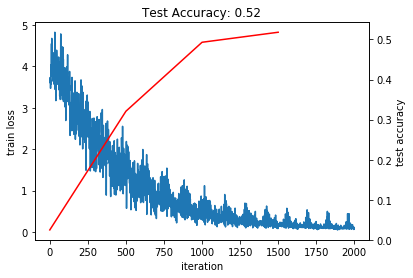

In [16]:
_, ax1 = subplots()
ax2 = ax1.twinx()
ax1.plot(arange(niter), train_loss)
ax2.plot(test_interval * arange(len(test_acc)), test_acc, 'r')
ax1.set_xlabel('iteration')
ax1.set_ylabel('train loss')
ax2.set_ylabel('test accuracy')
ax2.set_title('Test Accuracy: {:.2f}'.format(test_acc[-1]))